,T1,T2,Q1,Q2
Time,,,,
0.0,21.221,21.446,50.0,0.0
10.0,21.253,21.511,50.0,0.0
20.0,22.188,21.575,50.0,0.0
30.0,23.477,21.672,50.0,0.0
40.0,24.991,21.897,50.0,0.0
...,...,...,...,...
560.0,52.803,36.722,50.0,0.0
570.0,52.803,36.786,50.0,0.0
580.0,52.803,36.754,50.0,0.0


<AxesSubplot:xlabel='time / seconds'>

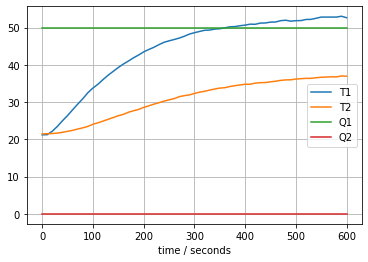

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# read data file from the Github repository into a Pandas dataframe
data_location = "https://jckantor.github.io/cbe30338-2021/data/Model_Data.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)

# simple plotting
expt.plot(grid=True, xlabel="time / seconds")

In [2]:
google_sheet_id = "1rV_oimh-GCYNP-xRP1HNrLvh7P4jZBSmwuqG3VPIaB0"
google_csv_download = f"https://docs.google.com/spreadsheets/d/{google_sheet_id}/gviz/tq?tqx=out:csv"

# write your code here

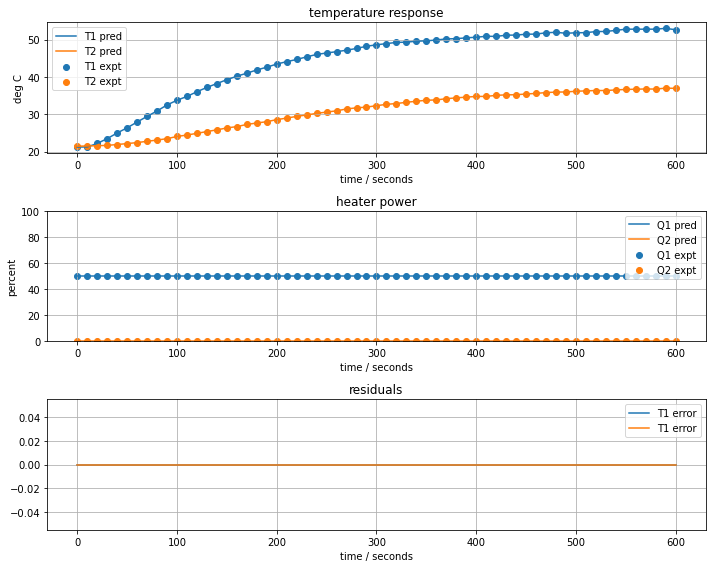

In [3]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return
    
# demonstrate by comparing experimental data to itself
plot_data(expt, expt);

Time
0.0     -0.221000
10.0     2.126065
20.0     3.343731
30.0     4.002544
40.0     4.250999
           ...   
560.0   -6.895447
570.0   -6.886649
580.0   -6.878689
590.0   -7.096486
600.0   -6.703969
Name: T1, Length: 61, dtype: float64

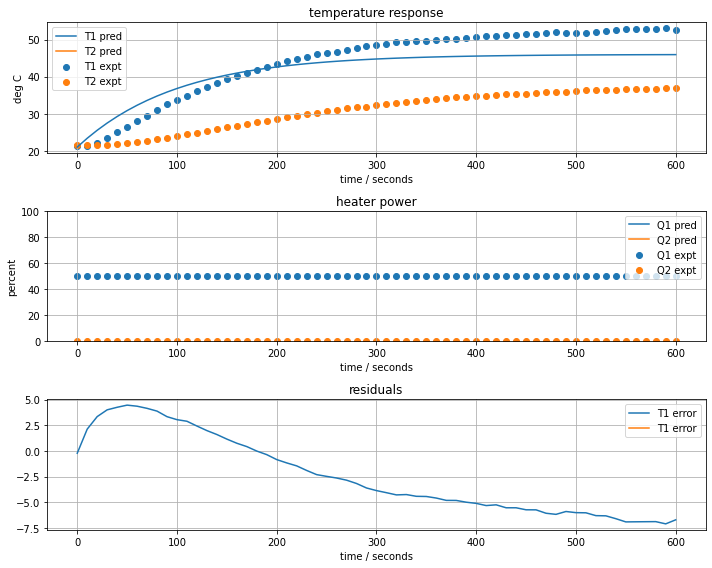

In [4]:
# known parameters
T_amb = 21
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable model parameters
K = 0.5
tau = 100

# create function to create predictions and return residuals
def model_first_order(param, plot=False):
    # unpack list of parameters into variables
    K, tau = param
    
    # create empty prediction data frame
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    
    # calculation prediction
    pred["T1"] = T_amb + K*u1bar*(1 - np.exp(-t_expt/tau))
    
    # plot if desired
    if plot:
        plot_data(expt, pred)
        
    # return residual difference between prediction and experiment
    return pred["T1"] - expt["T1"]

# compare prediction to experiment
model_first_order([K, tau], True)

K = 0.6810786741681504,  tau = 196.35954289720914


Time
0.0     -0.221000
10.0     1.437844
20.0     2.109734
30.0     2.347839
40.0     2.285121
           ...   
560.0    0.284868
570.0    0.382487
580.0    0.475259
590.0    0.338425
600.0    0.808213
Name: T1, Length: 61, dtype: float64

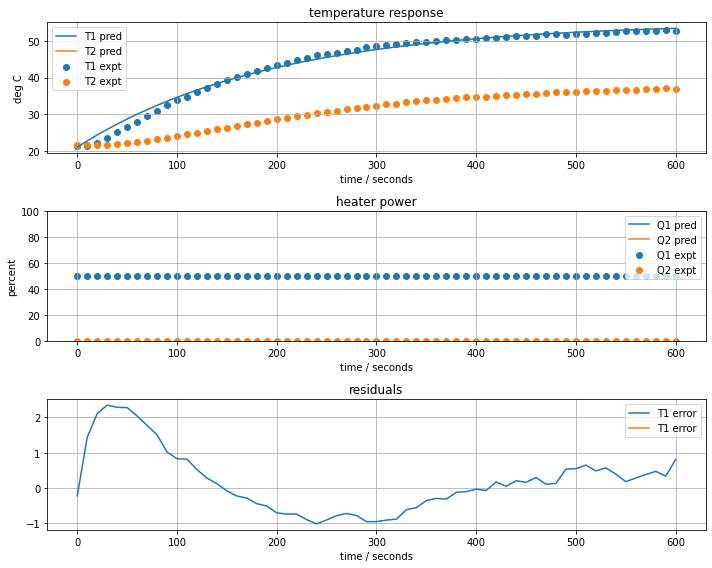

In [5]:
results = least_squares(model_first_order,  [K, tau])
K, tau = results.x
print(f"K = {K},  tau = {tau}")
model_first_order(results.x, True)

Time
0.0     -0.221000
10.0    -0.253000
20.0     0.746790
30.0     1.267800
40.0     1.447077
           ...   
560.0   -2.569846
570.0   -2.520390
580.0   -2.474123
590.0   -2.655840
600.0   -2.229349
Name: T1, Length: 61, dtype: float64

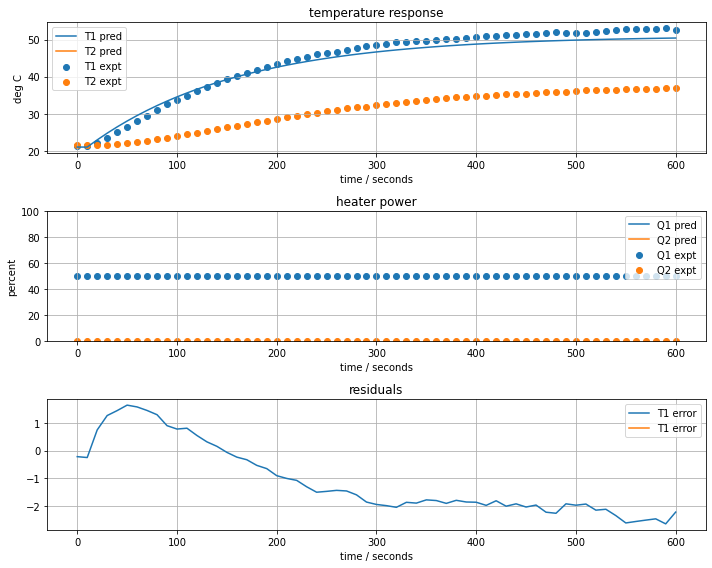

In [6]:
# parameter values and units
T_amb = 21                 # deg C
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable parameters
K = 0.6
tau = 150
t_delay = 10

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt]
    if plot:
        plot_data(expt, pred)
    return pred["T1"] - expt["T1"]
    
model_first_order_delay([K, tau, t_delay], True)

K = 0.6520728535022049,  tau = 154.47860603780478, time delay = 21.77205414050518


Time
0.0     -0.221000
10.0    -0.253000
20.0    -1.188000
30.0    -0.785879
40.0    -0.362185
           ...   
560.0   -0.199623
570.0   -0.136923
580.0   -0.078154
590.0   -0.248068
600.0    0.189565
Name: T1, Length: 61, dtype: float64

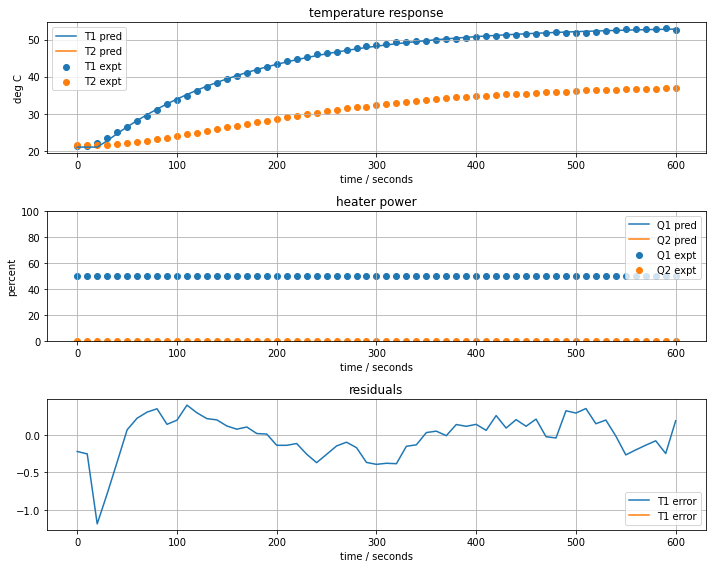

In [7]:
results = least_squares(model_first_order_delay,  [K, tau, t_delay])
K, tau, t_delay = results.x
print(f"K = {K},  tau = {tau}, time delay = {t_delay}")
model_first_order_delay(results.x, True)

In [8]:
# parameter values and units
T_amb = 21             # deg C
P1 = 200               # P1 units
P2 = 100               # P2 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# input function
def u1(t):
    return np.interp(t, t_expt, expt["Q1"])

def u2(t):
    return np.interp(t, t_expt, expt["Q2"])

Time
0.0     -0.221000
10.0     2.305582
20.0     3.724586
30.0     4.601597
40.0     5.082666
           ...   
560.0   -0.111357
570.0   -0.086947
580.0   -0.064244
590.0   -0.268356
600.0    0.136861
Name: T1, Length: 61, dtype: float64

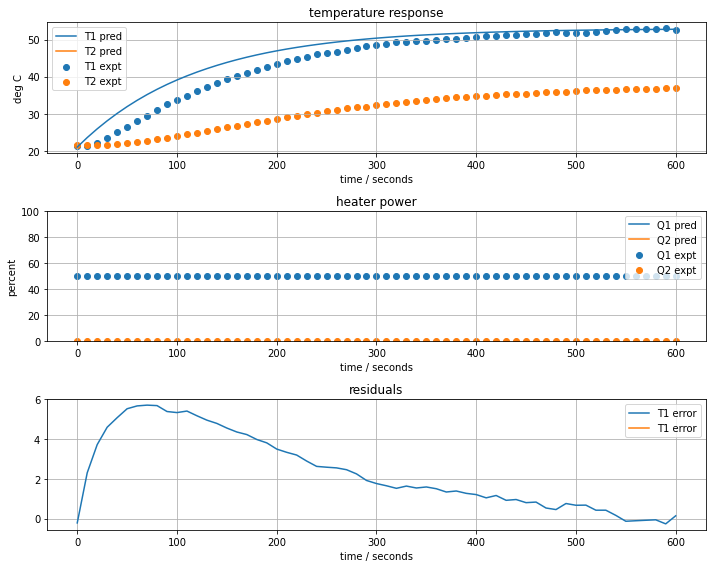

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
Cp = 6                 # joules/deg C
Ua = 0.05              # watts/deg C

def model_energy_first_order(param, plot=False):
    # unpack the adjustable parameters
    Cp, Ua = param

    # model solution
    def deriv(t, y):
        T1 = y[0]
        return -(Ua/Cp)*T1 + (alpha*P1/Cp)*u1(t) + (Ua/Cp)*T_amb

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[0]

    # plot solution
    if plot:
        plot_data(expt, pred)
        
    return pred["T1"] - expt["T1"]
    
model_energy_first_order([Cp, Ua], True)

Cp = 9.229887391953215,  Ua = 0.04697145247995448


Time
0.0     -0.221000
10.0     1.437129
20.0     2.108397
30.0     2.345975
40.0     2.283636
           ...   
560.0    0.285966
570.0    0.382852
580.0    0.475093
590.0    0.338030
600.0    0.808001
Name: T1, Length: 61, dtype: float64

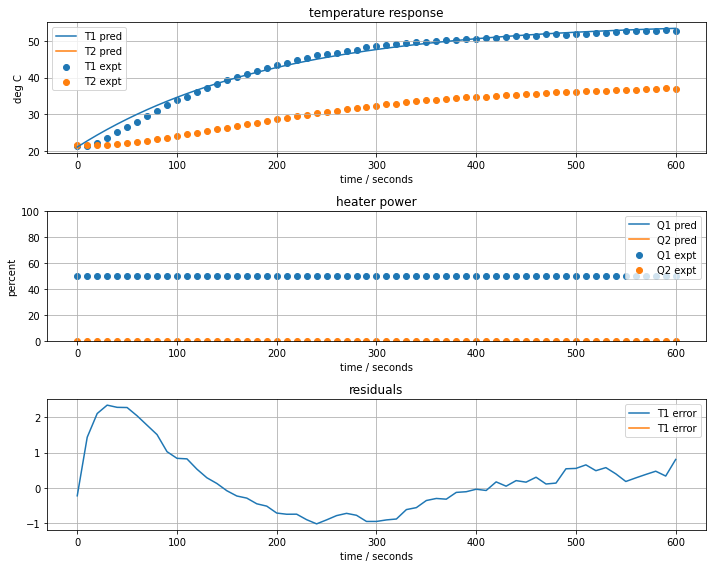

In [10]:
results = least_squares(model_energy_first_order,  [Cp, Ua])
Cp, Ua = results.x
print(f"Cp = {Cp},  Ua = {Ua}")
model_energy_first_order(results.x, True)

Time
0.0     -0.221000
10.0     0.371773
20.0     0.895562
30.0     1.395004
40.0     1.774688
           ...   
560.0   -0.210368
570.0   -0.188967
580.0   -0.148499
590.0   -0.323733
600.0    0.093363
Name: T1, Length: 61, dtype: float64

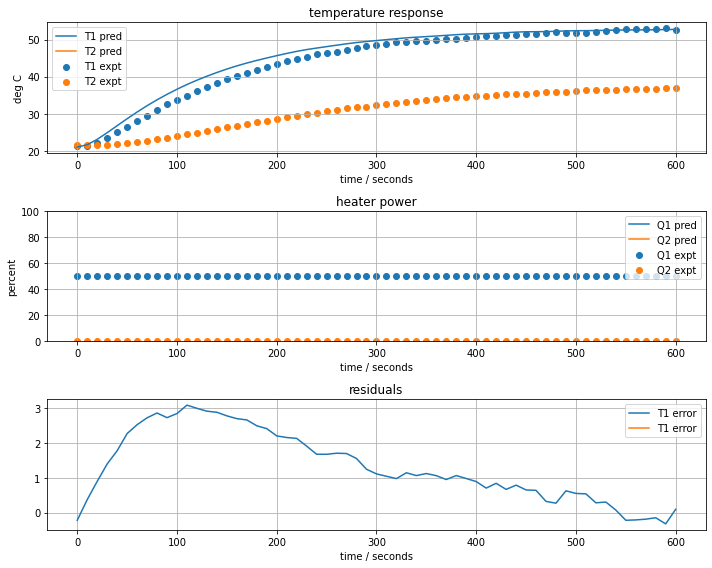

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C


def model_energy_second_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub = param

    # model solution
    def deriv(t, y):
        T1H, T1S = y
        dT1H = (-(Ua + Ub)*T1H + Ub*T1S + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        return [dT1H, dT1S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb, T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
        
    return pred["T1"] - expt["T1"]
    
model_energy_second_order([CpH, CpS, Ua, Ub], plot=True)

CpH = 2.181913430002232,  CpS = 1.878311673223082,   Ua = 0.049566616420126,  Ub = 0.021187798515331504


Time
0.0     -0.221000
10.0     0.104481
20.0     0.063797
30.0    -0.007664
40.0    -0.117127
           ...   
560.0   -0.289050
570.0   -0.245878
580.0   -0.203222
590.0   -0.386367
600.0    0.039924
Name: T1, Length: 61, dtype: float64

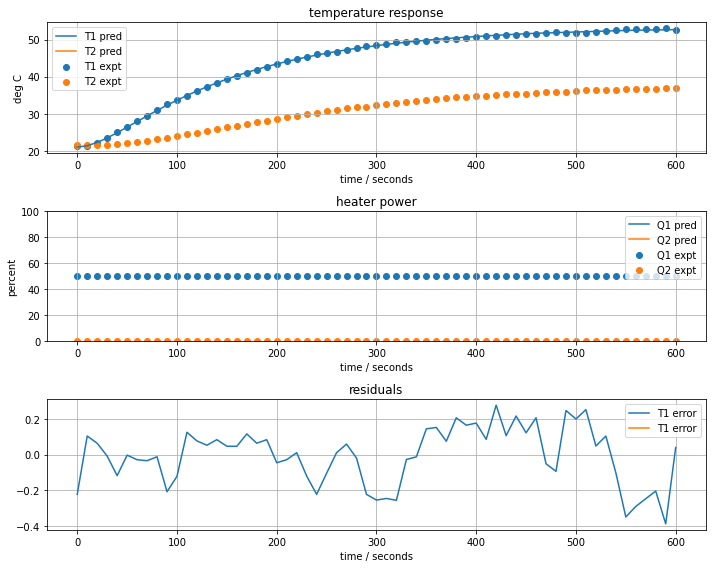

In [12]:
results = least_squares(model_energy_second_order,  [CpH, CpS, Ua, Ub])
CpH, CpS, Ua, Ub = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub}")
model_energy_second_order(results.x, True)

array([ -0.221     ,   0.34640496,   0.76940428,   1.05824442,
         1.13171249,   1.24645305,   1.07316775,   0.81586616,
         0.48007917,  -0.13344645,  -0.48890253,  -0.70921588,
        -1.25124638,  -1.76745403,  -2.20823788,  -2.69742627,
        -3.14122854,  -3.52330422,  -4.01831601,  -4.40206324,
        -4.88886002,  -5.19721912,  -5.48385191,  -5.96815841,
        -6.40553965,  -6.57439776,  -6.70435903,  -6.9013846 ,
        -7.2455444 ,  -7.69003022,  -7.92579427,  -8.09662387,
        -8.30244458,  -8.28467125,  -8.45397113,  -8.44203263,
        -8.55229841,  -8.76329137,  -8.79264212,  -8.97090733,
        -9.05270848,  -9.21073629,  -9.11325468,  -9.42975647,
        -9.44638557,  -9.61415333,  -9.564619  ,  -9.87641255,
       -10.01102868,  -9.74099527,  -9.82511837,  -9.804095  ,
       -10.08438906, -10.11845575, -10.39033103, -10.67585924,
       -10.64774194, -10.64625393, -10.63882106, -10.84765596,
       -10.44699971,  -0.446     ,  -0.48503157,  -0.44

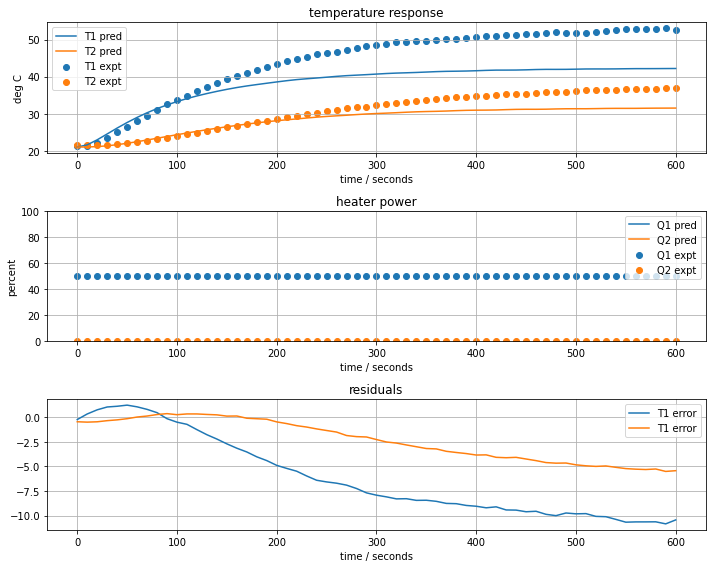

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.05              # watts/deg C

def model_energy_fourth_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  

    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*T1H + Ub*T1S + Uc*T2H + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*T2H + Ub*T2S + Uc*T1H + alpha*P2*u2(t) + Ua*T_amb)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]
    pred["T2"] = soln.y[3]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    err1 = np.array(pred["T1"] - expt["T1"])
    err2 = np.array(pred["T2"] - expt["T2"])
    
    return np.concatenate((err1, err2))
    
model_energy_fourth_order([CpH, CpS, Ua, Ub, Uc], plot=True)

CpH = 4.464221324963928,  CpS = 0.8190632549481232,   Ua = 0.03222673546626909,  Ub = 0.01862454317667063,  Uc = 0.03355402365567492


array([-0.221     ,  0.10032876,  0.05752012, -0.00405225, -0.10773458,
        0.0192058 ,  0.0218163 ,  0.0326821 ,  0.05934018, -0.12621612,
       -0.02560722,  0.2215558 ,  0.15911065,  0.12013859,  0.14267438,
        0.09875148,  0.08540208,  0.13037078,  0.05135854,  0.04902877,
       -0.09703126, -0.09303594, -0.06500138, -0.20674535, -0.32566402,
       -0.22615479, -0.12616152, -0.08732123, -0.16917965, -0.37119121,
       -0.39871903, -0.38303494, -0.38631947, -0.15266182, -0.13605994,
        0.01670925,  0.02122978, -0.05314746,  0.08779112,  0.06239944,
        0.09510969,  0.0284298 ,  0.24477422,  0.09824704,  0.22744493,
        0.14545712,  0.23302568, -0.01549287, -0.04315279,  0.31607629,
        0.29086152,  0.36550674,  0.18295255,  0.25477625,  0.05819189,
       -0.19055655, -0.1262411 , -0.06348873, -0.00238626, -0.16838582,
        0.27369522, -0.446     , -0.50119112, -0.51353832, -0.49453371,
       -0.52704116, -0.52492946, -0.46191418, -0.43668744, -0.33

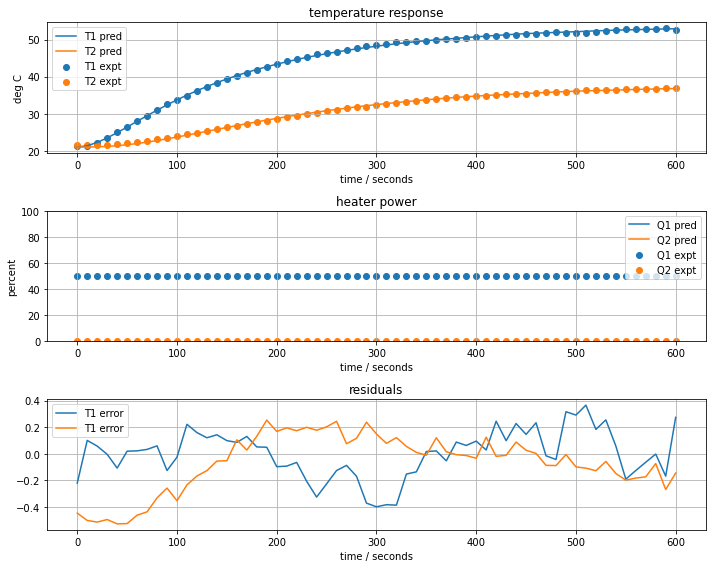

In [14]:
results = least_squares(model_energy_fourth_order,  [CpH, CpS, Ua, Ub, Uc])
CpH, CpS, Ua, Ub, Uc = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub},  Uc = {Uc}")
model_energy_fourth_order(results.x, True)